# Implementing JPEG Data Compression in Python

## Table of Contents
* [Introduction](#Introduction)
* [Python Implementation](#Implementation)
* [Applying Filters](#Applying)

<a id="Introduction"></a>
## Introduction

In the era of big data, data compression is very important to save space witout losing much information. There are different ways of compressing data, especially images. Some of them are loseless in which no information is lost when it is compressed. However, some others are losy in which a little data is lost.

In this homework, we are going to implement and apply one way of compressing images. This uses discrete fourier transforms (DCT). Although it is a lossy type of compression, not much information is lost as the original and the recovered images are not usually distinguishable. However much space is saved by using this method for compression. There are several steps that are done to apply it. These are:
* Image broken into 8x8 pixel blocks
* DCT applied for each block
* Each block is then quantized by some quantization matrix
* Then, it is flattened in a zigzag fashion.
* All the non-zero DCT coefficients are then coded to some binary bits by using an encoding table.

Finally, the series of the resulting bits is stored in a disk. The image can then decompression by following the steps in reverse order.

Here, we are going to calculate the compression ratio of some given images. That is, we are going to see how much are the images compressed.

<a id="Implementation"></a>
## Python Implementation

Let's first import the common classes.

In [18]:
from CommonClasses.utils import *
from CommonClasses.dct import *

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [19]:
def quantizeDCTImage(dctImge, Q):
    """Computes the quantized DCT image by dividing each 8x8 block
    of the DCT image by the quantization matrix."""
    
    N = dctImge.shape[0]
    blockN = Q.shape[0]
    qDctImge = np.zeros([N, N], dtype=int)
    for i in np.arange(0, N, 8):
        for j in np.arange(0, N, 8):
            qDctImge[i:(i+blockN), j:(j+blockN)] = (
                np.round(dctImge[i:(i+blockN), j:(j+blockN)]/Q))
    
    return qDctImge    

In [20]:
def constructZigzagArray(mat):
    """Constructs the flattened array from a given matrix by going in a zigzag fashion."""
    
    N = mat.shape[0]
    lstResult = []
    iPlus = False
    tPlus = True
    t = 0
    j = 1
    
    while True:
        if tPlus:
            if iPlus:
                for i in xrange(t+1):
                    lstResult.append(mat[i, t-i])
            else:
                for i in xrange(t, -1, -1):
                    lstResult.append(mat[i, t-i])
            t += 1
            iPlus = not iPlus

            if t == N:
                tPlus = not tPlus
        else:
            k = t-1
            if iPlus:
                for i in xrange(j, t):
                    lstResult.append(mat[i, k])
                    k -= 1
            else:
                for i in xrange(j, t):
                    lstResult.append(mat[k, i])
                    k -= 1
            j += 1
            iPlus = not iPlus
            if j>t:
                break
    return np.array(lstResult)

In [29]:
def findDCCodes(binDC, Codes):
    """Finds the category of the DC value"""
    baseCode = Codes[:, 1]
    l = len(binDC)
    indx = None
    subDC = None
    length = 0
    for i in xrange(l):
        subDC = binDC[:(i+1)]
        loc = np.nonzero(Codes[:, 1] == subDC)[0]
        if loc.size:
            indx = loc[0]
            length = int(Codes[indx, 2])
            break
    return indx, subDC, length       

In [30]:
def changeToHexDigit(num):
    if (num==10) or (num=='10'):
        return 'A'
    elif (num==11) or (num=='11'):
        return 'B'
    elif (num==12) or (num=='12'):
        return 'C'
    elif (num==13) or (num=='13'):
        return 'D'
    elif (num==14) or (num=='14'):
        return 'E'
    elif (num==15) or (num=='15'):
        return 'F'
    return str(num)

In [31]:
def computeDctJpegCompression(imge):
    """Computes the DCT JPEG Compression algorithm on a given image"""

    #Load the quantization matrix
    Q = np.loadtxt('JPEG_Code_Tables/Quantization_Matrix.txt', delimiter='\t', dtype=int)

    #Load the JPEG DC Encodings
    DC_Codes = np.loadtxt('JPEG_Code_Tables/JPEG_DC_Codes.txt', delimiter='\t', dtype=str)

    #Load the JPEG AC Encodings
    AC_Codes = np.loadtxt('JPEG_Code_Tables/JPEG_AC_Codes.txt', delimiter='\t', dtype=str)

    #Variable to store the resulting codes.
    result = ''
    
    N = imge.shape[0]
    blockN = Q.shape[0]
    previousDC = None
    for i in np.arange(0, N, blockN):
        for j in np.arange(0, N, blockN):
            # 1. Extract one block of the image at a time.
            blockImge = imge[i:(i+blockN), j:(j+blockN)]
            
            # 2. Apply DCT to the block
            blockImgeDct = DCT.computeForward2DDCT(blockImge)
            
            # 3. Quantize the resulting DCT values (i.e., divide by Q matrix and round)
            blockImgeDctQ = (blockImgeDct/Q).astype(int)
            
            # 4.1. Flatten the quantized image by using zigzag fashion.
            blockImgeDctQFlat = constructZigzagArray(blockImgeDctQ)
            # 4.2. Trim the trailing zeros from the array
            blockImgeDctQFlat = np.trim_zeros(blockImgeDctQFlat, trim='b')
            #print blockImgeDctQFlat
            
            #Encode the DCT values (trailing zeros are deleted)
            #A. DC Codes
            if blockImgeDctQFlat.size == 0:
                DC = 0
            else:
                DC = blockImgeDctQFlat[0]
            if previousDC is None:
                previousDC = DC
            else:
                temp = previousDC
                DC -= previousDC
                previousDC = temp
            #Convert to binary
            if DC==0:
                binDC = '00'
            else:
                binDC = binary_repr(abs(DC))
            #Search in category and substring of binDC in DC Encodings
            indx, subDC, length = findDCCodes(binDC, DC_Codes)
            if DC < 0:
                #Flip 0's and 1's
                binDC = ''.join('1' if x == '0' else '0' for x in binDC)
            #print "binDC: ", binDC
            #print "subDC: ", subDC
            #print "length: ", length
            binDC = binDC.zfill(length-len(subDC))
            DC_Code = subDC + binDC
            result += DC_Code
            
            #B. AC Codes
            runs = 0
            for i in range(1, blockImgeDctQFlat.size):
                AC = blockImgeDctQFlat[i]
                if AC == 0:
                    runs += 1
                else:
                    binAC = binary_repr(abs(AC))
                    length = len(binAC)
                    
                    if runs > 15:
                        runs = 15
                    indx = AC_Codes[:, 0:2].tolist().index([str(changeToHexDigit(runs)), str(length)])
                    baseCode = AC_Codes[indx, 2]
                    length = int(AC_Codes[indx, 3])
                    if AC < 0:
                        #Flip 0's and 1's
                        binAC = ''.join('1' if x == '0' else '0' for x in binAC)
                    binAC = binAC.zfill(length-len(baseCode))
                    AC_Code = baseCode + binAC
                    result += AC_Code
                    runs = 0
            
            #Add EOB Code at the end of the encoded block.
            result += AC_Codes[0, 2]
            
    return result, len(result)
    

<a id="Applying"></a>
## Applying The Compression

N.B. In this example, only one quantization matrix is applied. However, it can be changed to any other matrix. The quantization matrix determines the level of compression. In other words, different quantization matrix give different compressed images. According, the quality of the recovered images are also different. Usually, the higher the compression ratio for the same image the lower is the quality of the recovered/decompressed image.

In [32]:
#Load or generate images

#1. Generate an image with a white square at its center and black background.
imge = Images.generateBlackAndWhiteSquareImage(512)

#Load other images from file.
imgeHouse = Image.open(r'Images/house.jpg') # open an image
imgePepper = Image.open(r'Images/peppers_gray.jpg') # open an image

#Convert from 3-D to 2-D
imgeHouse = imgeHouse.convert(mode='L')
imgePepper = imgePepper.convert(mode='L')

#Convert the image file to a matrix
imgeHouse = np.array(imgeHouse)
imgePepper = np.array(imgePepper)

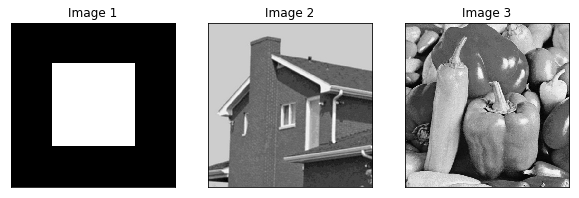

In [33]:
#Let's now display the images
fig, axarr = plt.subplots(1, 3, figsize=[10,5])

axarr[0].imshow(imge, cmap=plt.get_cmap('gray'))
axarr[0].set_title("Image 1")
axarr[0].axes.get_xaxis().set_visible(False)
axarr[0].axes.get_yaxis().set_visible(False)

axarr[1].imshow(imgeHouse, cmap=plt.get_cmap('gray'))
axarr[1].set_title("Image 2")
axarr[1].axes.get_xaxis().set_visible(False)
axarr[1].axes.get_yaxis().set_visible(False)

axarr[2].imshow(imgePepper, cmap=plt.get_cmap('gray'))
axarr[2].set_title("Image 3")
axarr[2].axes.get_xaxis().set_visible(False)
axarr[2].axes.get_yaxis().set_visible(False)


In [34]:
#Calculate the size of the images
N_imge = imge.shape[0]
N_Pepper = imgePepper.shape[0]
N_House = imgeHouse.shape[0]

In [35]:
#Calculate the uncompressed image size(For 8-bit grayscale image)
uncompSize_imge = (N_imge**2)*8
uncompSize_Pepper = (N_Pepper**2)*8
uncompSize_House = (N_House**2)*8

In [36]:
#Calculate the compressed images' size
_, compSize_imge = computeDctJpegCompression(imge)

In [37]:
_, compSize_Pepper = computeDctJpegCompression(imgePepper)

In [38]:
_, compSize_House = computeDctJpegCompression(imgeHouse)

In [39]:
#Calculate the compression ratio of the images
print "Image 1 Compression Ratio: ", int(uncompSize_imge/compSize_imge)
print "Image 2 Compression Ratio: ", int(uncompSize_House/compSize_House)
print "Image 3 Compression Ratio: ", int(uncompSize_Pepper/compSize_Pepper)

Image 1 Compression Ratio:  45
Image 2 Compression Ratio:  54
Image 3 Compression Ratio:  16


From the above results, the images with a highly correlated have higher compression ratios than those of the decorrelated images.